## Imbalance dataset

In [2]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

print(torch.__version__)

notebook_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)


2.2.2
/Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction


### Import current imputed dataset

In [ ]:
# DATA_PATH = get_data.get_dataset_abspath()
# load_path = os.path.join(DATA_PATH, "imputed_sofa.parquet")
# imputed_df = pd.read_parquet(load_path)

# imputed_df.head(5)

In [3]:
from utils import get_data

DATA_PATH = get_data.get_dataset_abspath()
load_path = os.path.join(DATA_PATH, "imputed_combined_data.parquet")
imputed_df = pd.read_parquet(load_path)


In [4]:
imputed_df.head(5)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,dataset,cluster_id
0,102.108491,91.419811,36.789519,128.165094,88.199717,71.73211,24.712264,-0.288406,23.835971,0.467029,...,83.14,0,0.715787,0.284213,-0.03,1,0,1,A,0_9_2_2_X_X_X
1,97.000000,95.000000,36.789519,98.000000,75.330000,71.73211,19.000000,-0.288406,23.835971,0.467029,...,83.14,0,0.715787,0.284213,-0.03,2,0,1,A,0_9_2_2_X_X_X
2,89.000000,99.000000,36.789519,122.000000,86.000000,71.73211,22.000000,-0.288406,23.835971,0.467029,...,83.14,0,0.715787,0.284213,-0.03,3,0,1,A,0_9_2_2_X_X_X
3,90.000000,95.000000,36.789519,122.000000,88.665000,71.73211,30.000000,24.000000,23.835971,0.467029,...,83.14,0,0.715787,0.284213,-0.03,4,0,1,A,0_9_2_2_X_X_X
4,103.000000,88.500000,36.789519,122.000000,91.330000,71.73211,24.500000,-0.288406,23.835971,0.280000,...,83.14,0,0.715787,0.284213,-0.03,5,0,1,A,0_9_2_2_X_X_X


In [5]:
unique_patients = imputed_df['patient_id'].nunique()
positive_patients = imputed_df.groupby('patient_id')['SepsisLabel'].max().sum()
percentage_positive = (positive_patients / unique_patients) * 100
print("Total patients:", unique_patients)
print("Percentage of true positive sepsis patients: {:.2f}%".format(percentage_positive))

Total patients: 40336
Percentage of true positive sepsis patients: 7.27%


In [6]:
groputed_by_patient = imputed_df.groupby('patient_id').head(1)

### Quick exploration

Label 0: 37404 (92.73%)
Label 1: 2932 (7.27%)


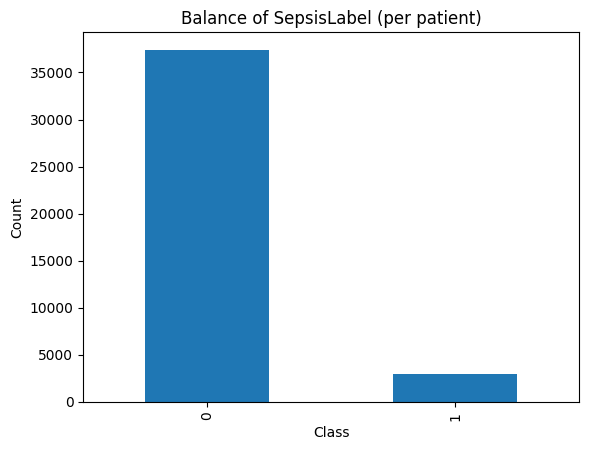

Patient-level balance statistics:
Total patients: 40336
Label 0: 37404 patients (92.73%)
Label 1: 2932 patients (7.27%)
Imbalance ratio (majority/minority): 12.76

Reflection:
Positive cases are only 7.27% of patients. This is very low for our sepsis challenge.
Consider applying resampling or cost-sensitive methods to create a richer dataset for training.


In [8]:
def balance_report(df):
    patient_df = df.groupby("patient_id")["SepsisLabel"].max().reset_index()
    counts = patient_df["SepsisLabel"].value_counts()
    total = counts.sum()
    for label, count in counts.items():
        print(f"Label {label}: {count} ({(count / total * 100):.2f}%)")
    
    counts.plot(kind="bar", title=f"Balance of SepsisLabel (per patient)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

def display_balance_statistics(df, plot=True):
    patient_df = df.groupby("patient_id")["SepsisLabel"].max().reset_index()
    counts = patient_df["SepsisLabel"].value_counts()
    total_patients = counts.sum()
    print("Patient-level balance statistics:")
    print("Total patients:", total_patients)
    for label, count in counts.items():
        perc = (count / total_patients) * 100
        print(f"Label {label}: {count} patients ({perc:.2f}%)")
    if len(counts) >= 2:
        imbalance_ratio = counts.max() / counts.min()
        print(f"Imbalance ratio (majority/minority): {imbalance_ratio:.2f}")
    else:
        print("Only one class present; check your data!")
    
    minority_percentage = counts.min() / total_patients * 100
    print("\nReflection:")
    if minority_percentage < 10:
        print(f"Positive cases are only {minority_percentage:.2f}% of patients. This is very low for our sepsis challenge.")
        print("Consider applying resampling or cost-sensitive methods to create a richer dataset for training.")
    else:
        print("The balance between classes seems acceptable.")


balance_report(imputed_df)
display_balance_statistics(imputed_df)

## Technique 1: balance dataset with oversample / undersample

In [9]:
from sklearn.utils import resample


def balance_over_under_sample(df, method="oversample", minority_ratio=0.5):
    """
    Balances a hospital dataset at the patient level.
    Each patient's label is determined by taking the max of the target column 
    (assumes that if any record is positive, the patient is positive)
    """
    # Aggregate patient-level labels.
    patient_df = df.groupby("patient_id")['SepsisLabel'].max().reset_index()

    # Identify majority and minority classes.
    counts = patient_df["SepsisLabel"].value_counts()
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    majority_patients = patient_df[patient_df["SepsisLabel"] == majority_class]
    minority_patients = patient_df[patient_df["SepsisLabel"] == minority_class]

    # Resample at the patient level.
    if method == "oversample":
        n_samples = int(len(majority_patients) * minority_ratio)
        minority_upsampled = resample(minority_patients, replace=True,
                                      n_samples=n_samples, random_state=42)
        balanced_patient_df = pd.concat(
            [majority_patients, minority_upsampled])
    elif method == "undersample":
        n_samples = int(len(minority_patients) / minority_ratio)
        majority_downsampled = resample(majority_patients, replace=False,
                                        n_samples=n_samples, random_state=42)
        balanced_patient_df = pd.concat(
            [majority_downsampled, minority_patients])
    else:
        raise ValueError("Method must be 'oversample' or 'undersample'")

    # Reconstruct the full dataset by concatenating records for each patient.
    balanced_df = pd.concat(
        [df[df["patient_id"] == pid]
            for pid in balanced_patient_df["patient_id"]],
        ignore_index=True
    )

    return balanced_df


### Oversample

Label 0: 37404 (92.74%)
Label 1: 2928 (7.26%)


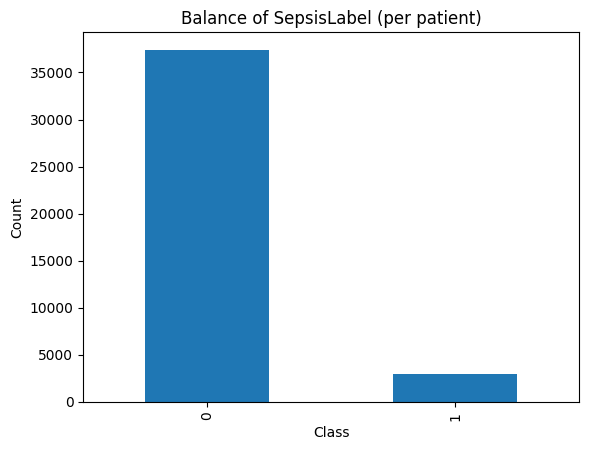

Patient-level balance statistics:
Total patients: 40332
Label 0: 37404 patients (92.74%)
Label 1: 2928 patients (7.26%)
Imbalance ratio (majority/minority): 12.77

Reflection:
Positive cases are only 7.26% of patients. This is very low for our sepsis challenge.
Consider applying resampling or cost-sensitive methods to create a richer dataset for training.


In [10]:
balanced_df = balance_over_under_sample(imputed_df, method="oversample", minority_ratio=0.5)
balance_report(balanced_df)
display_balance_statistics(balanced_df)

### Undersample

### Metric

## Technique 2